#### Correlation
Raw pulse에서 Loran-chain detection을 위해서, correlation을 수행한다. correlation의 대상은 Raw-pulse와 chain별 Reference Signal이다. Correlation 결과값을 통해 Reference siganl의 위치를 파악하고, 각 chain의 위치를 파악할 수 있다.  

-------------------------------------------------------------

#### 코드설명
##### 라이브러리
코드 내에서 사용된 라이브러리는 아래와 같다. 'reference_signal`의 경우, 이번 분석을 통해 작성한 API로 Reference Signal을 작성하는 기능을 포함하고 있다. master pulse와 slave pulse만을 단독으로 생성할 수도 있고, chain형태로 pulse를 생성할 수도 있다.  
- 라이브러리 리스트
    1. `os` 
        - 폴더 접근, path 등을 조작할 수 이는 라이브러리
    2. `numpy`
        - 행렬 연산 기능들을 모아 놓은 라이브러리
    3. `scipy`
        - 통계 및 다양한 공학 연산을 지원하는 `scipy`의 여러 기능들 중, `scipy.signal` 내에 cross-correlation 기능을 가진, `correlate`, `correlation_lag` 을 사용하여, 신호들의 **cross-correlation**을 수행함
    4. `matplotlib` : 
        - 데이터 시각화와 관련된 기능들을 모아놓은 라이브러리
    5. `reference_signal`
        - reference signal을 생성하는 기능을 가진 모듈

In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal as sgl
import reference_signal as rs

##### 데이터로드
현재 코드가 있는 경로에 data 폴더 내부에 있는 파일 중 `raw_data_0304_160Mbps_5sec.cap0`를 로드한 후, 50000000개의 데이터만을 선택하여 raw_data 변수에 저장한다.

In [2]:
path = './data'
file_name = 'raw_data_0304_160Mbps_5sec.cap0'
raw_data = np.fromfile(os.path.join(path, file_name), dtype='int16')

In [3]:
raw_data = raw_data[:50000000]

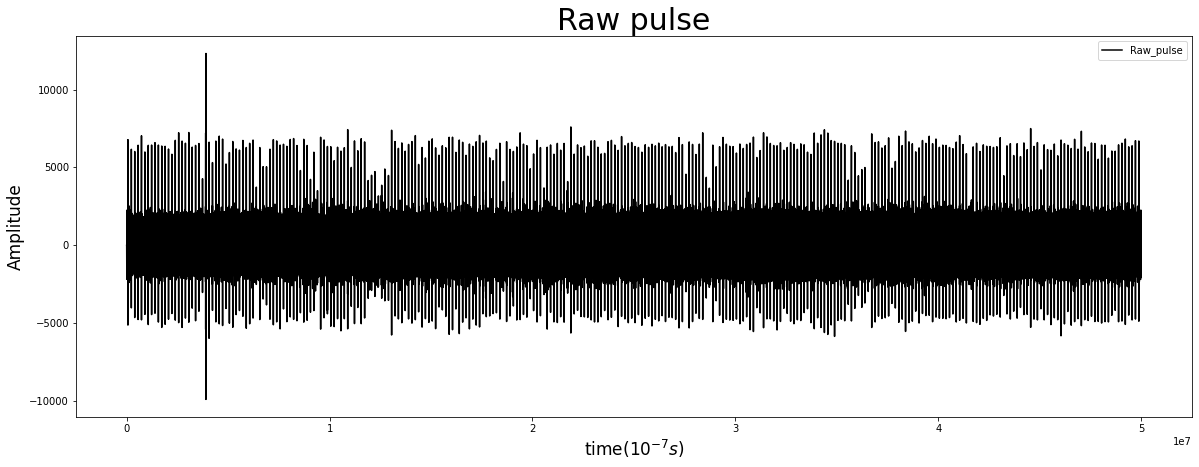

In [4]:
plt.figure(figsize=(20,7))
plt.plot(raw_data, 'k', label='Raw_pulse')
plt.xlabel('time($10^{-7}s$)', fontsize=17)
plt.ylabel('Amplitude', fontsize=17)
plt.title('Raw pulse', fontsize=30)
plt.legend(loc='upper right')
plt.show()

##### Filtering and Normalization
데이터 Correlation 이전에, 결과값을 보다 효과적으로 보기 위해, 눈에 띄는 큰 노이즈를 제거하고, noramlization을 통해 reference window와 스케일을 맞춘다. 데이터간의 차이를 확인하기 위해, 2x2의 figure를 ploting 했으며, 각각 filtering과 normalization 처리 여부를 나타내었다.

In [5]:
filtered_data = raw_data.copy()
filtered_data[filtered_data > 8000] = 0
filtered_data[filtered_data < -6000] = 0


In [6]:
normalized_rd = (raw_data - np.min(raw_data))/(np.max(raw_data) - np.min(raw_data))
normalized_fd = (filtered_data - np.min(filtered_data))/(np.max(filtered_data) - np.min(filtered_data))

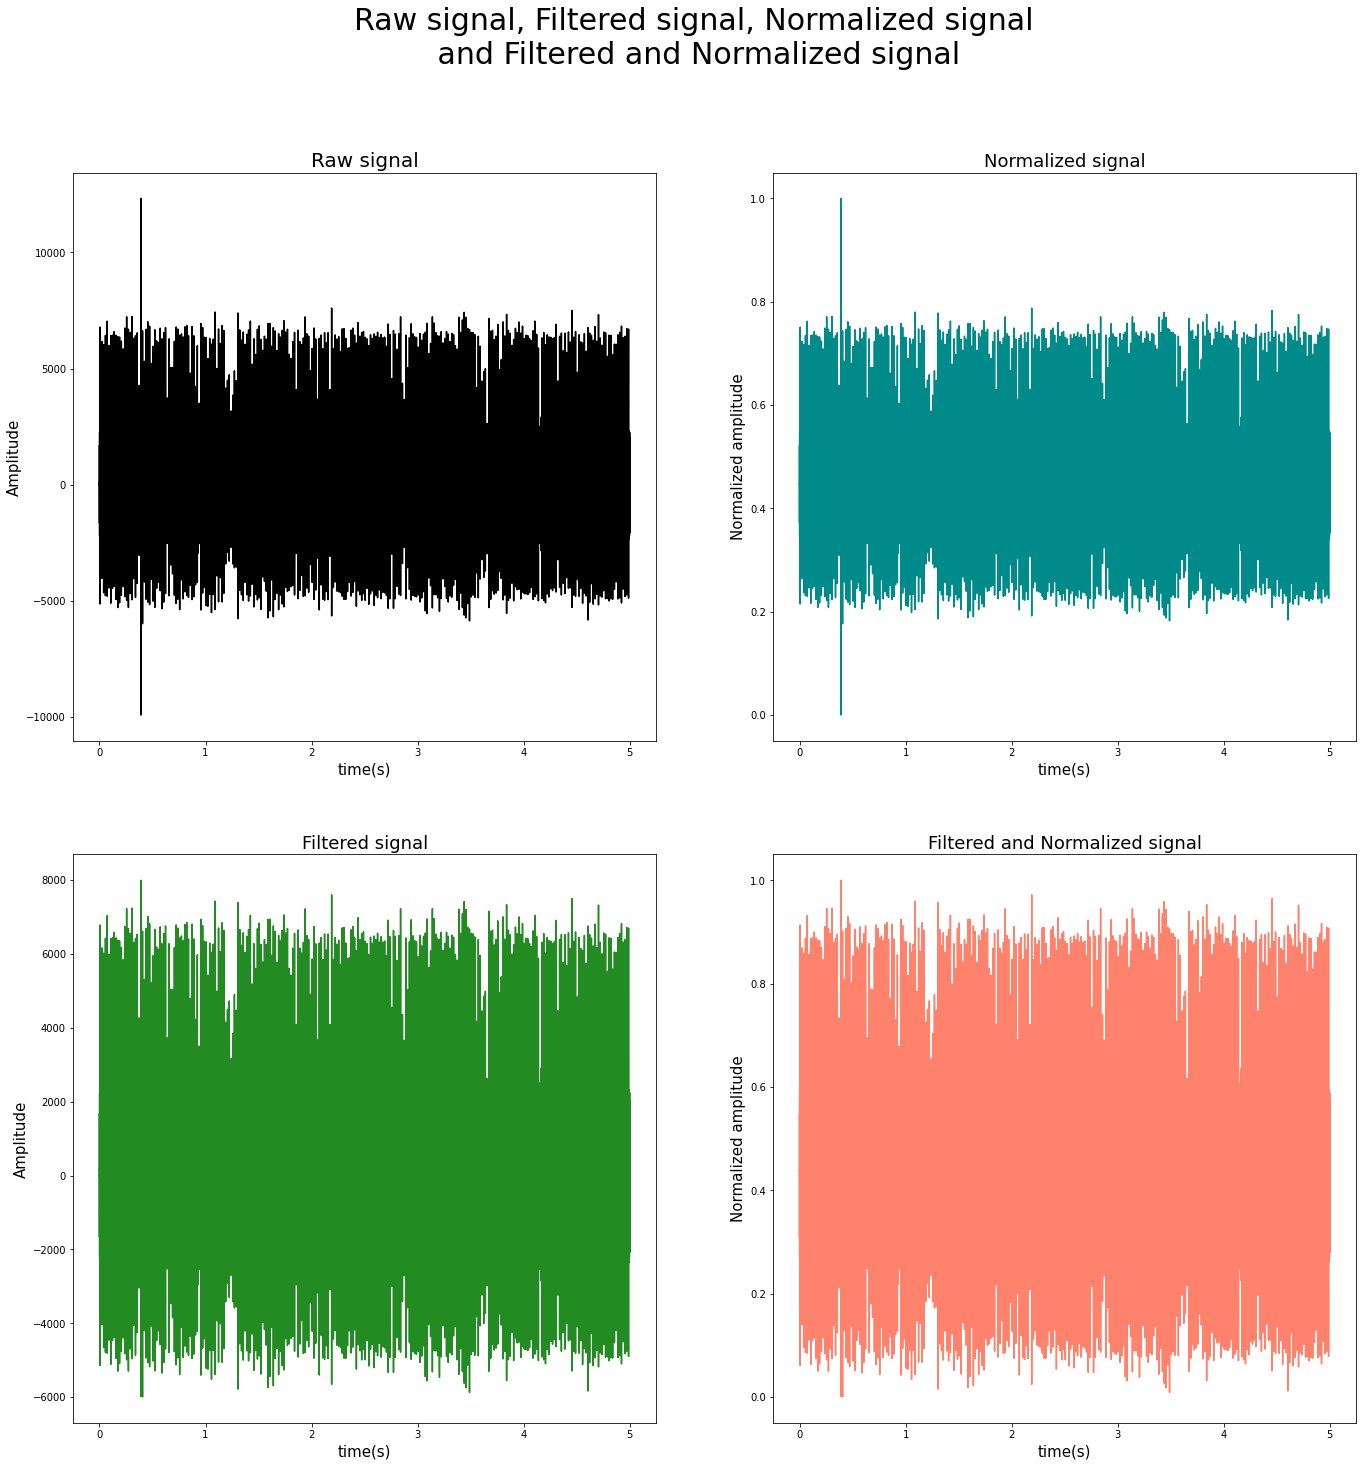

In [7]:
timespace = np.linspace(0, 5, 50000000)

fig, axes = plt.subplots(2, 2, figsize=(23, 23))
axes[0][0].plot(timespace, raw_data, 'k')
axes[0][0].set_title("Raw signal", fontsize=20)
axes[0][0].set_xlabel("time(s)", fontsize=15)
axes[0][0].set_ylabel("Amplitude", fontsize=15)

axes[0][1].plot(timespace, normalized_rd, 'darkcyan')
axes[0][1].set_title("Normalized signal", fontsize=18)
axes[0][1].set_xlabel("time(s)", fontsize=15)
axes[0][1].set_ylabel("Normalized amplitude", fontsize=15)

axes[1][0].plot(timespace, filtered_data, 'forestgreen')
axes[1][0].set_title("Filtered signal", fontsize=18)
axes[1][0].set_xlabel("time(s)", fontsize=15)
axes[1][0].set_ylabel("Amplitude", fontsize=15)

axes[1][1].plot(timespace, normalized_fd, 'tomato', alpha=0.8, label='filtered & normalized')
axes[1][1].set_title("Filtered and Normalized signal", fontsize=18)
axes[1][1].set_xlabel("time(s)", fontsize=15)
axes[1][1].set_ylabel("Normalized amplitude", fontsize=15)
#axes[1][1].plot(timespace, raw_data, 'slategrey', alpha=0.3, label='raw')

plt.suptitle("Raw signal, Filtered signal, Normalized signal\n and Filtered and Normalized signal", fontsize=30)

plt.show()

##### Reference window
사용되는 Reference window들은 각각 '7430 China North Sea chain', '8390 China East Sea chain', '9930 East Asia chain' 이다. 각각의 chain들에 사용되는 master-pulse와 slave-pulse는 차이가 없으며, chain별로 master/slave pulse의 amplitude의 amplitude에서는 차이를 보인다. 현재는 Reference들을 참고하여 비율을 평균내어 값을 선정하였다. Refence signal 생성에는 `reference_signal.py` API를 로드하여 사용한다. Reference window들의 enveloped signal은 `orangered` 색상으로 표현되었고, phase-code의 적용을 확인하기 위해 Reference window에 같이 ploting된다.  

Master-pulse, Slave-pusle 그리고 각 체인별 reference window를 분석 전에 시각화하면 다음과 같다.

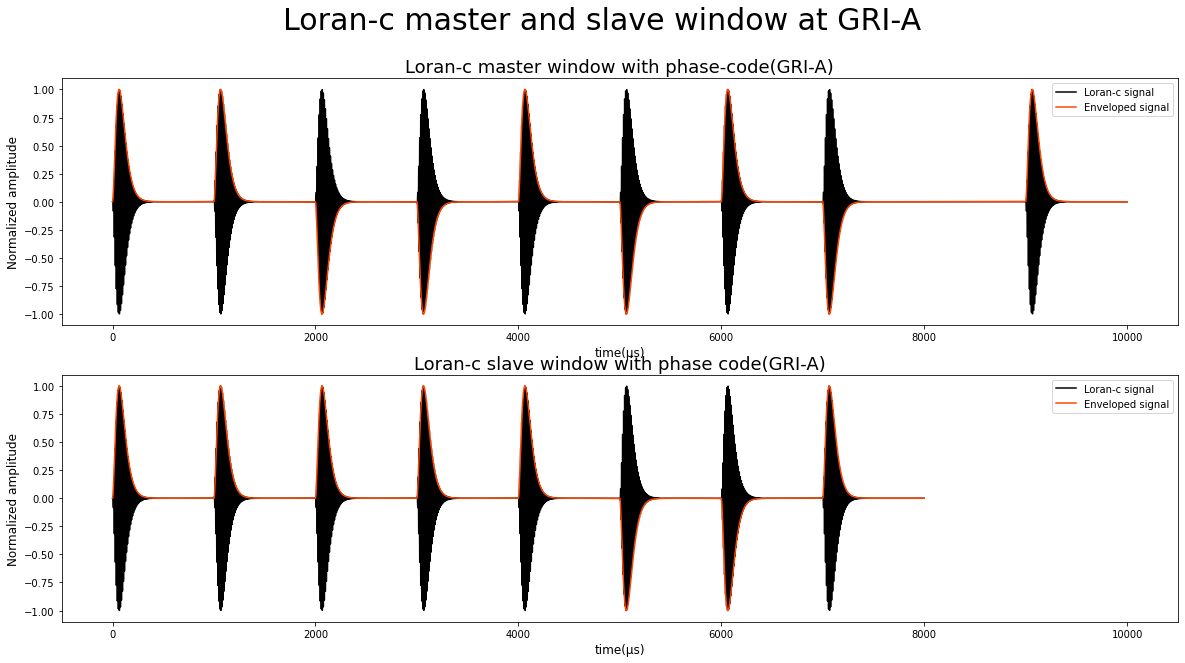

In [8]:
# Generate master and slave window
gri_a_m = ['+', '+', '-', '-', '+', '-', '+', '-', 'dummy', '+']
gri_a_s = ['+', '+', '+', '+', '+', '-', '-', '+']
gri_b_m = ['+', '-', '-', '+', '+', '+', '+', '+', 'dummy', '-']
gri_b_s = ['+', '-', '+', '-', '+', '+', '-', '-'] 

pci = [[gri_a_m, gri_a_s], [gri_b_m, gri_b_s]]

# Master Signal
timespace_m, master_window, master_window_e = rs.gen_master_window(phase_code=gri_a_m)
timespace_s, slave_window, slave_window_e = rs.gen_slave_window(phase_code=gri_a_s)

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
plt.suptitle("Loran-c master and slave window at GRI-A", fontsize=30)
axes[0].plot(timespace_m, master_window, 'k', label='Loran-c signal')
axes[0].plot(timespace_m, master_window_e, 'orangered', label='Enveloped signal')
axes[0].set_xlim(-500, 10500)
axes[0].set_title("Loran-c master window with phase-code(GRI-A)", fontsize=18)
axes[0].set_xlabel("time(μs)", fontsize=12)
axes[0].set_ylabel("Normalized amplitude", fontsize=12)
axes[0].legend(loc='upper right')

axes[1].plot(timespace_s, slave_window, 'k', label='Loran-c signal')
axes[1].plot(timespace_s, slave_window_e, 'orangered', label='Enveloped signal')
axes[1].set_xlim(-500, 10500)
axes[1].set_title("Loran-c slave window with phase code(GRI-A)", fontsize=18)
axes[1].set_xlabel("time(μs)", fontsize=12)
axes[1].set_ylabel("Normalized amplitude", fontsize=12)
axes[1].legend(loc='upper right')

plt.show()

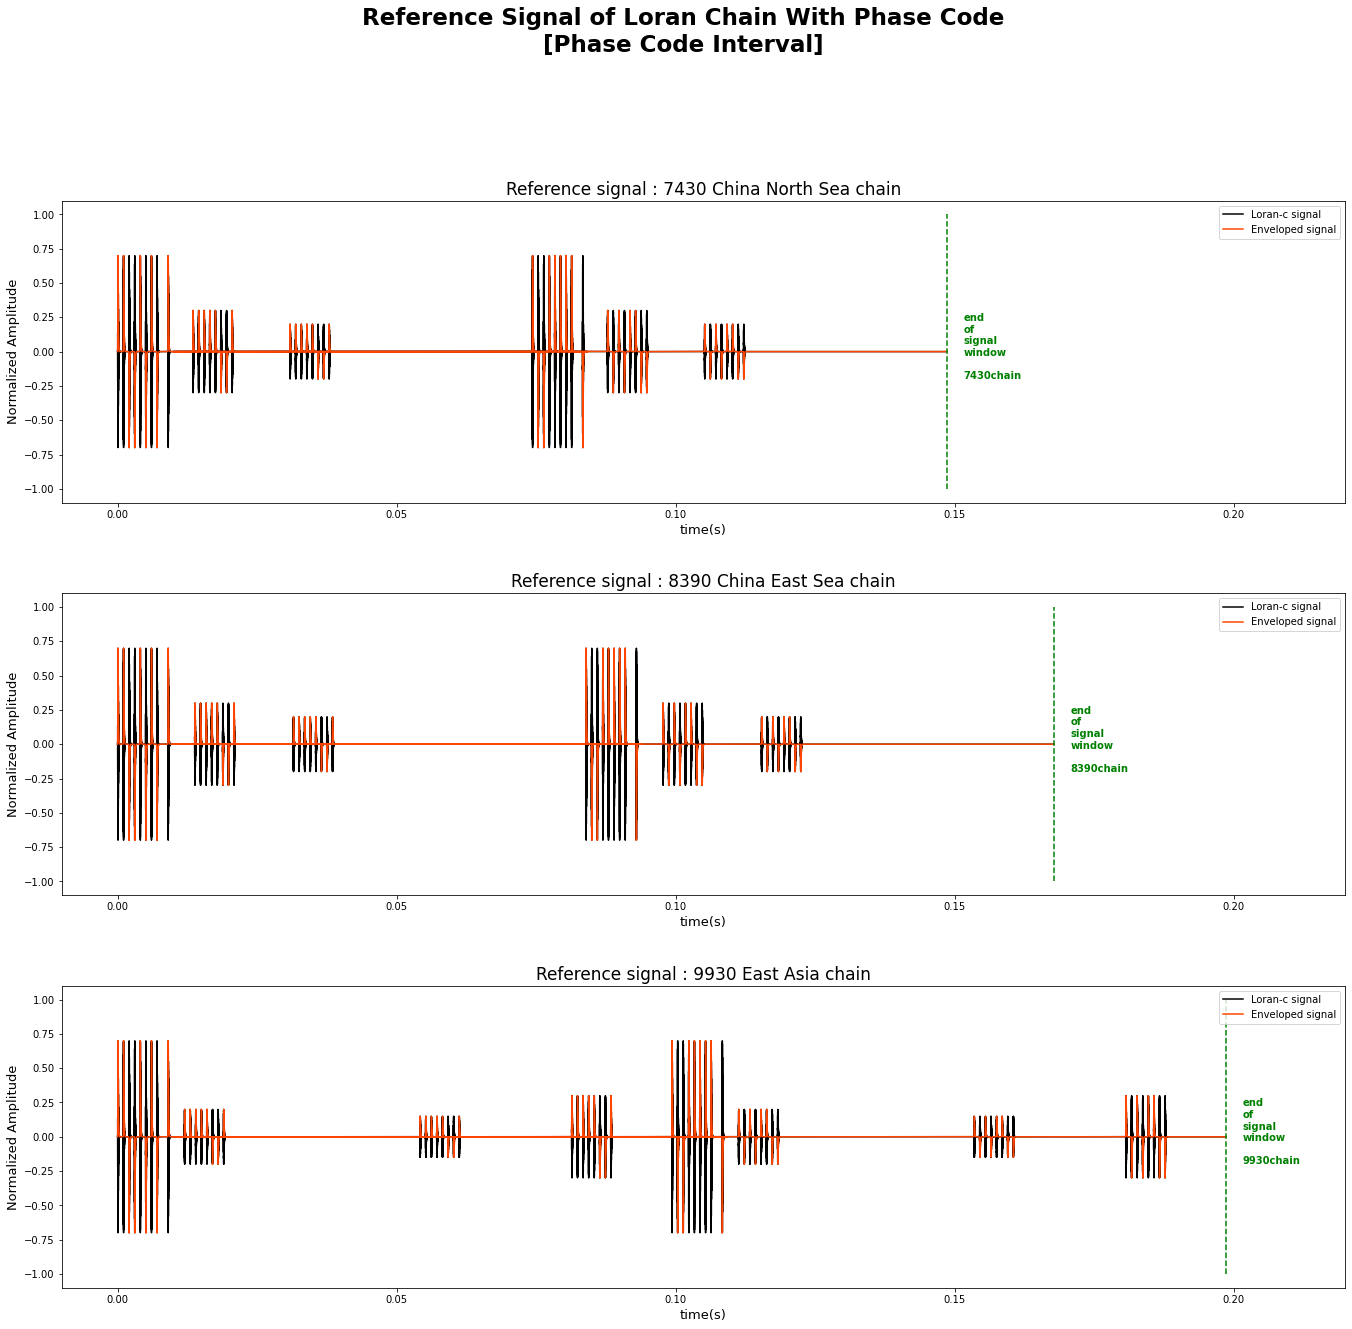

In [9]:
id_list = [7430, 8390, 9930]

fig, axes = plt.subplots(3, 1, figsize=(23, 20))

plt.suptitle("Reference Signal of Loran Chain With Phase Code\n[Phase Code Interval]", 
             fontsize=23, weight='bold', ha='center', va='bottom')

axes_num = 0


for id_ in id_list:
    temp_time, temp_signal, temp_signal_e, id_chain = rs.merge_signal_by_id(id_)
    temp_time = temp_time / 1e6
    # Line plot : signal data, enveloped signal
    axes[axes_num].plot(temp_time, temp_signal, 'k', label='Loran-c signal')
    axes[axes_num].plot(temp_time, temp_signal_e, 'orangered', label='Enveloped signal')
    
    # Line for checking end-point
    axes[axes_num].vlines(id_*1e-5*2, -1, 1, color='green', linestyles='--')
    
    # Text for checking end-point
    axes[axes_num].text(id_*1e-5*2+0.003, -0.2, 'end\nof\nsignal\nwindow\n\n'+str(id_)+'chain', color='green', weight='bold')
    
    # Plot settings : xlim, xlabel, ylabel, legend
    axes[axes_num].set_xlim(-0.01, 0.22)
    axes[axes_num].set_title('Reference signal : '+ id_chain, fontsize=17)
    axes[axes_num].set_xlabel('time(s)', fontsize=13)
    axes[axes_num].set_ylabel('Normalized Amplitude', fontsize=13)
    axes[axes_num].legend(loc='upper right')
    
    axes_num += 1

plt.subplots_adjust(hspace=0.3)

plt.show()

##### Correlation

Reference와 correlation을 통해, 각 chain의 위치를 확인할 수 있으며 이를 통해 chain을 분류할 수 있다. 각 cahin별로 correlation결과를 reference signal과 함께 plotting 했다.

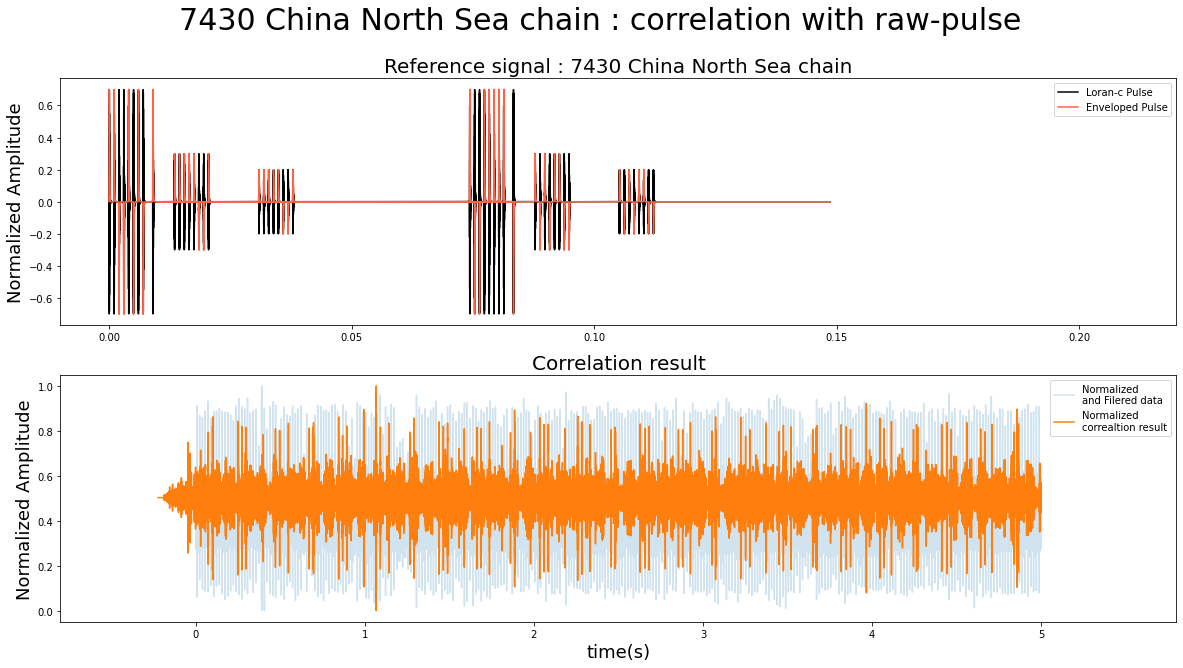

In [10]:

timespace, signal, signal_e, id_chain = rs.merge_signal_by_id(id=7430)

#1
corr = sgl.correlate(normalized_fd, signal, mode='full')
lags = sgl.correlation_lags( len(normalized_fd), len(signal), mode='full')

normalized_corr = (corr - np.min(corr))/(np.max(corr) - np.min(corr))
time_ = np.arange(0, len(normalized_fd))
time_ = time_ / 1e7
lags = lags / 1e7
timespace = timespace / 1e6

fig, axes = plt.subplots(2, 1, figsize=(20,10))
plt.suptitle(id_chain+" : correlation with raw-pulse", fontsize=30)

axes[0].plot(timespace, signal, 'black', label='Loran-c Pulse')
axes[0].plot(timespace, signal_e, 'tomato', label='Enveloped Pulse')
axes[0].set_xlim(-0.01, 0.22)
axes[0].set_ylabel("Normalized Amplitude", fontsize=18)
axes[0].legend(loc='upper right')
axes[0].set_title("Reference signal : " + id_chain, fontsize=20)

axes[1].plot(time_, normalized_fd, alpha=0.2, label='Normalized\nand Filered data')
axes[1].plot(lags, normalized_corr, label='Normalized\ncorrealtion result')
axes[1].set_xlim(-0.8, 5.8)
axes[1].set_xlabel("time(s)", fontsize=18)
axes[1].set_ylabel("Normalized Amplitude", fontsize=18)
axes[1].legend(loc='upper right')
axes[1].set_title("Correlation result", fontsize=20)

plt.show()


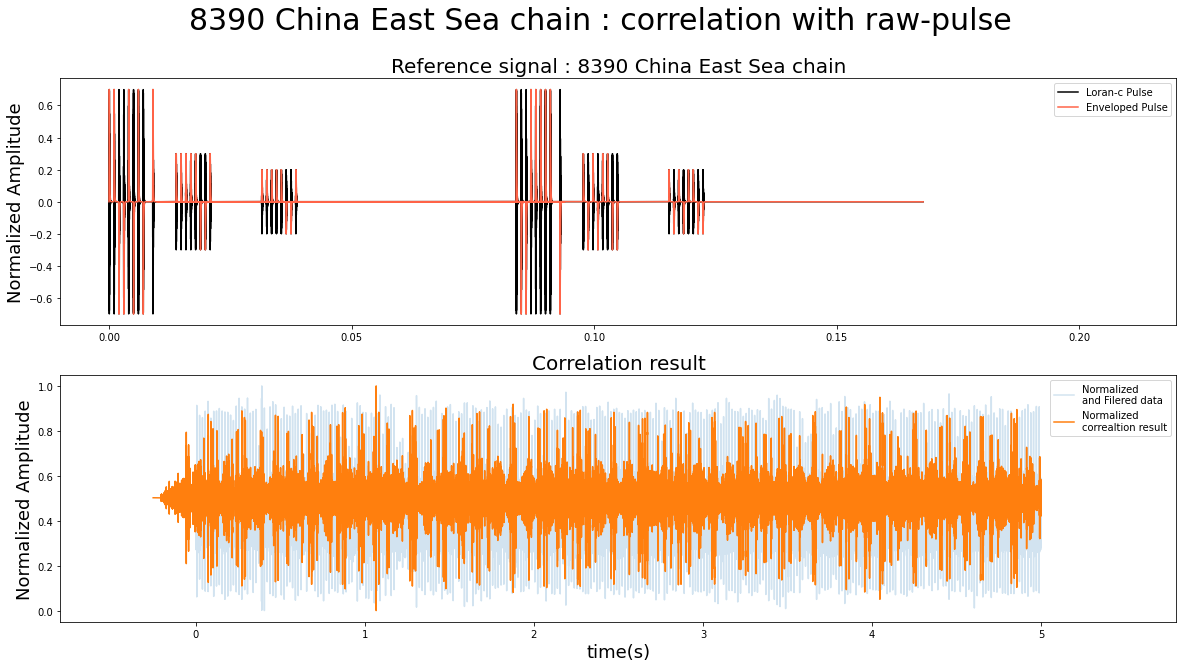

In [11]:

timespace, signal, signal_e, id_chain = rs.merge_signal_by_id(id=8390)

#1
corr = sgl.correlate(normalized_fd, signal, mode='full')
lags = sgl.correlation_lags( len(normalized_fd), len(signal), mode='full')

normalized_corr = (corr - np.min(corr))/(np.max(corr) - np.min(corr))
time_ = np.arange(0, len(normalized_fd))
time_ = time_ / 1e7
lags = lags / 1e7
timespace = timespace / 1e6

fig, axes = plt.subplots(2, 1, figsize=(20,10))
plt.suptitle(id_chain+" : correlation with raw-pulse", fontsize=30)

axes[0].plot(timespace, signal, 'black', label='Loran-c Pulse')
axes[0].plot(timespace, signal_e, 'tomato', label='Enveloped Pulse')
axes[0].set_xlim(-0.01, 0.22)
axes[0].set_ylabel("Normalized Amplitude", fontsize=18)
axes[0].legend(loc='upper right')
axes[0].set_title("Reference signal : " + id_chain, fontsize=20)

axes[1].plot(time_, normalized_fd, alpha=0.2, label='Normalized\nand Filered data')
axes[1].plot(lags, normalized_corr, label='Normalized\ncorrealtion result')
axes[1].set_xlim(-0.8, 5.8)
axes[1].set_xlabel("time(s)", fontsize=18)
axes[1].set_ylabel("Normalized Amplitude", fontsize=18)
axes[1].legend(loc='upper right')
axes[1].set_title("Correlation result", fontsize=20)

plt.show()

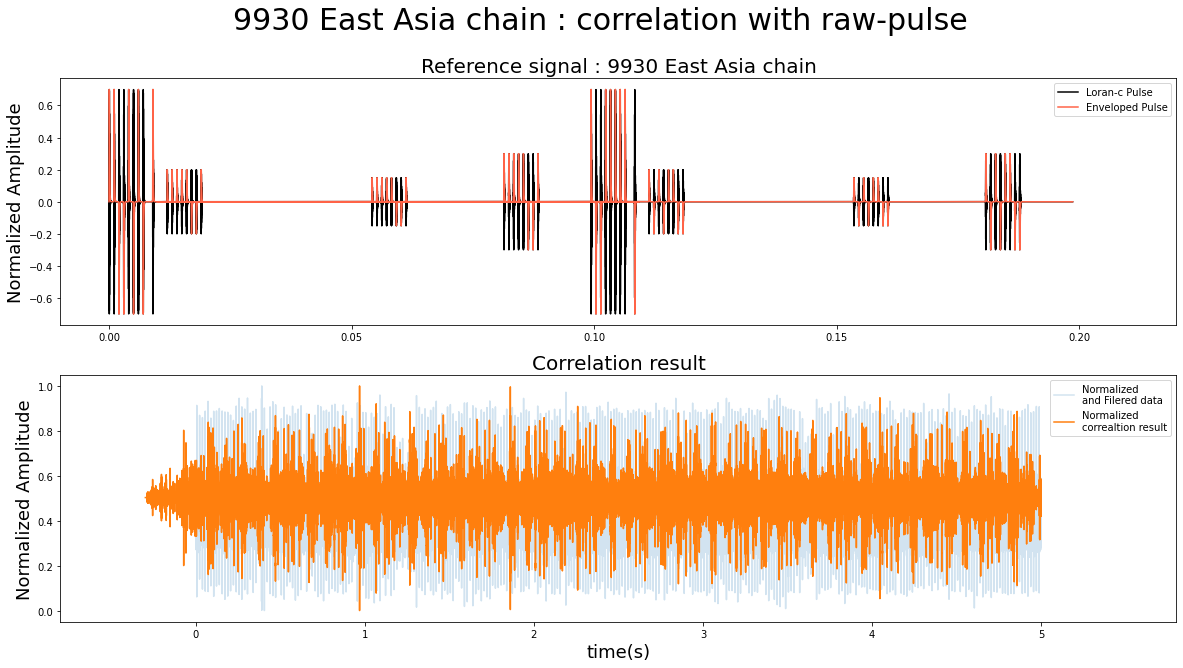

In [12]:

timespace, signal, signal_e, id_chain = rs.merge_signal_by_id(id=9930)

#1
corr = sgl.correlate(normalized_fd, signal, mode='full')
lags = sgl.correlation_lags( len(normalized_fd), len(signal), mode='full')

normalized_corr = (corr - np.min(corr))/(np.max(corr) - np.min(corr))
time_ = np.arange(0, len(normalized_fd))
time_ = time_ / 1e7
lags = lags / 1e7
timespace = timespace / 1e6

fig, axes = plt.subplots(2, 1, figsize=(20,10))
plt.suptitle(id_chain+" : correlation with raw-pulse", fontsize=30)

axes[0].plot(timespace, signal, 'black', label='Loran-c Pulse')
axes[0].plot(timespace, signal_e, 'tomato', label='Enveloped Pulse')
axes[0].set_xlim(-0.01, 0.22)
axes[0].set_ylabel("Normalized Amplitude", fontsize=18)
axes[0].legend(loc='upper right')
axes[0].set_title("Reference signal : " + id_chain, fontsize=20)

axes[1].plot(time_, normalized_fd, alpha=0.2, label='Normalized\nand Filered data')
axes[1].plot(lags, normalized_corr, label='Normalized\ncorrealtion result')
axes[1].set_xlim(-0.8, 5.8)
axes[1].set_xlabel("time(s)", fontsize=18)
axes[1].set_ylabel("Normalized Amplitude", fontsize=18)
axes[1].legend(loc='upper right')
axes[1].set_title("Correlation result", fontsize=20)

plt.show()

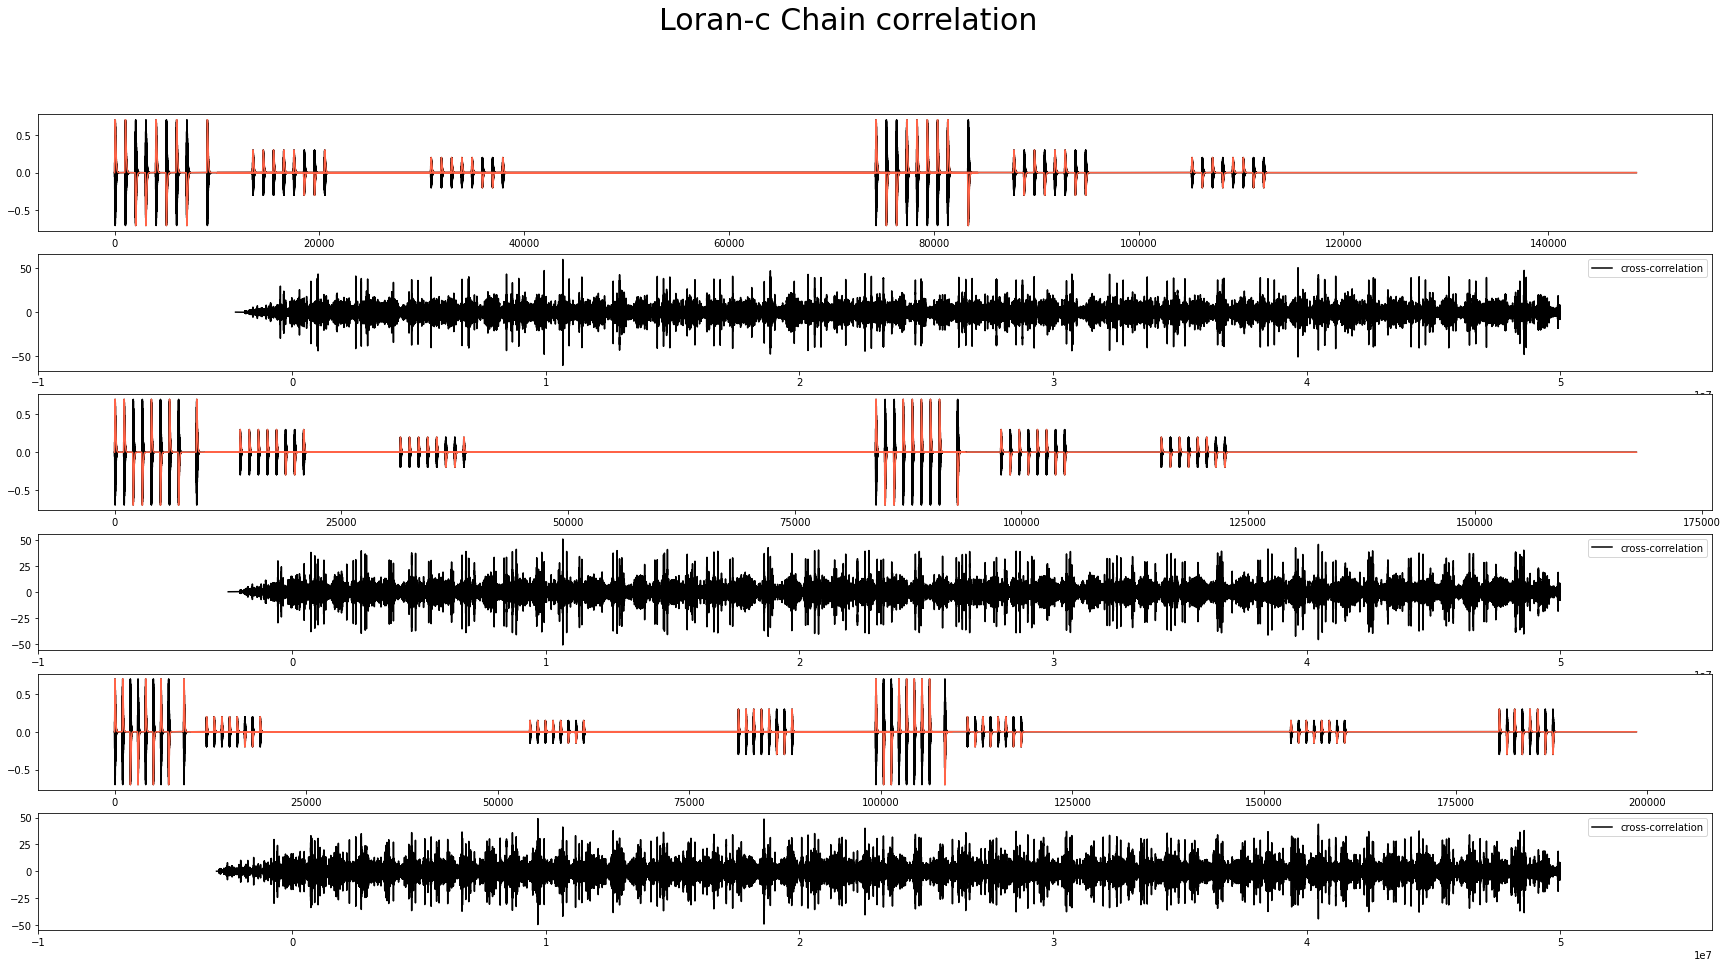

In [13]:
id_list = [7430, 8390, 9930]

fig, axes = plt.subplots(6, 1, figsize=(30, 15))
plt.suptitle("Loran-c Chain correlation", fontsize=30)
i = 0

for id_ in id_list:
    
    timespace, signal, signal_e, id_chain = rs.merge_signal_by_id(id=id_)

    corr = sgl.correlate(normalized_fd, signal, mode='full')
    lags = sgl.correlation_lags( len(normalized_fd), len(signal), mode='full')

    axes[i].plot(timespace, signal, 'k', label='Loran-c pulse')
    axes[i].plot(timespace, signal_e, 'tomato', label='Enveloped pulse')
    
    axes[i+1].plot(lags, corr, 'black', label='cross-correlation')
    axes[i+1].set_xlim(-1e7,5.6e7)
    axes[i+1].legend(loc='upper right')
    
    i += 2

plt.show()

    

In [24]:

timespace, signal, signal_e, id_chain = rs.merge_signal_by_id(id=9930)

#1
corr = sgl.correlate(normalized_fd, signal, mode='full')
lags = sgl.correlation_lags( len(normalized_fd), len(signal), mode='full')

normalized_corr = (corr - np.min(corr))/(np.max(corr) - np.min(corr))
time_ = np.arange(0, len(normalized_fd))
time_ = time_ / 1e7
lags = lags / 1e7
timespace = timespace / 1e6



In [27]:
a = normalized_corr.copy()
a[(a<0.8) & (a>0.2)] = 0.5

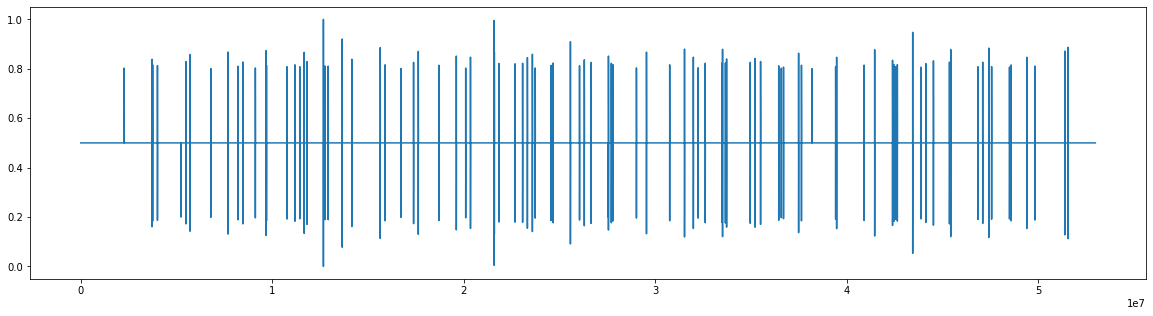

In [28]:
plt.figure(figsize=(20,5))
plt.plot(a)

plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20,10))
plt.suptitle(id_chain+" : correlation with raw-pulse", fontsize=30)

axes[0].plot(timespace, signal, 'black', label='Loran-c Pulse')
axes[0].plot(timespace, signal_e, 'tomato', label='Enveloped Pulse')
axes[0].set_xlim(-0.01, 0.22)
axes[0].set_ylabel("Normalized Amplitude", fontsize=18)
axes[0].legend(loc='upper right')
axes[0].set_title("Reference signal : " + id_chain, fontsize=20)

axes[1].plot(time_, normalized_fd, alpha=0.2, label='Normalized\nand Filered data')
axes[1].plot(lags, normalized_corr, label='Normalized\ncorrealtion result')
axes[1].set_xlim(-0.8, 5.8)
axes[1].set_xlabel("time(s)", fontsize=18)
axes[1].set_ylabel("Normalized Amplitude", fontsize=18)
axes[1].legend(loc='upper right')
axes[1].set_title("Correlation result", fontsize=20)

plt.show()